In [1]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Building a Conversational Search Agent with Reasoning Engine and RAG on Vertex AI Search

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/reasoning-engine/tutorial_vertex_ai_search_rag_agent.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Freasoning-engine%2Ftutorial_vertex_ai_search_rag_agent.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/reasoning-engine/tutorial_vertex_ai_search_rag_agent.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/reasoning-engine/tutorial_vertex_ai_search_rag_agent.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>


| | |
|-|-|
|Author(s) | [Kristopher Overholt](https://github.com/koverholt) |

## Overview

### Reasoning Engine in Vertex AI

[Reasoning Engine](https://cloud.google.com/vertex-ai/generative-ai/docs/reasoning-engine/overview) (LangChain on Vertex AI) is a managed service in Vertex AI that helps you to build and deploy an agent reasoning framework. It gives you the flexibility to choose how much reasoning you want to delegate to the LLM and how much you want to handle with customized code. You can define Python functions that get used as tools via [Gemini Function Calling](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/function-calling). Reasoning Engine integrates closely with the Python SDK for the Gemini model in Vertex AI, and it can manage prompts, agents, and examples in a modular way. Reasoning Engine is compatible with LangChain, LlamaIndex, or other Python frameworks.

### Objectives

In this tutorial, you will build and deploy an agent (model, tools, and reasoning) using the Vertex AI SDK for Python.

Your agent will use [LangChain](https://python.langchain.com/docs/get_started/introduction) and [Vertex AI Search](https://cloud.google.com/generative-ai-app-builder/docs/enterprise-search-introduction) to retrieve structured data indexed from the [Movies Dataset on Kaggle](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv) using retrieval augmented generation (RAG).

- Install the Vertex AI SDK for Python
- Define a model for your agent
- Define Python functions as tools so that our agent can:
   - Search and retrieve movie information from Vertex AI Search
- Use the LangChain agent template provided in the Vertex AI SDK for Reasoning Engine
- Test your agent locally before deploying
- Deploy and test your agent on Reasoning Engine in Vertex AI

### Enable APIs and Services

This tutorial uses the following billable components of Google Cloud, which you'll need to enable for this tutorial:

- [Enable Vertex AI API](https://console.cloud.google.com/apis/api/aiplatform.googleapis.com/overview)
- [Enable Vertex AI Search API](https://console.cloud.google.com/apis/api/discoveryengine.googleapis.com/overview)
- [Enable Resource Manager API](https://console.cloud.google.com/apis/api/cloudresourcemanager.googleapis.com/overview)

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Getting Started


### Install Vertex AI SDK for Python

Install the latest version of the Vertex AI SDK for Python and extra dependencies related to Reasoning Engine, LangChain, and Vertex AI Search:

In [2]:
!pip install --upgrade \
    google-cloud-aiplatform==1.50.0 \
    langchain==0.1.17 \
    langchain-google-vertexai==1.0.3 \
    langchain_google_community \
    google-cloud-discoveryengine \
    google-cloud-resource-manager

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [3]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>



### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).

In [4]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [5]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}
STAGING_BUCKET = "gs://[your-staging-bucket]"  # @param {type:"string"}

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION, staging_bucket=STAGING_BUCKET)

## Example: Building and Deploying a Conversational Search Agent for Movies

In this tutorial, you'll build Python functions as tools that the Gemini model will use to search for information about movies and ground its responses using a RAG implementation with Vertex AI Search.

### Import libraries

In [6]:
from google.cloud import resourcemanager_v3
from IPython.display import display, Markdown
from langchain.agents.format_scratchpad import format_to_openai_function_messages
from langchain_core import prompts
from langchain.memory import ChatMessageHistory
from vertexai.preview import reasoning_engines

### Define generative model

The first component of your agent involves the version of the generative model you want to use in your agent. Here you'll use the Gemini 1.5 Pro model:

In [7]:
model = "gemini-1.5-pro-preview-0409"

### Create a data store in Vertex AI Search

Now you'll create a data store within Vertex AI Search and index records from a movie data set.

Follow the tutorial steps in the Vertex AI Search documentation to [create and preview a search app for structured data](https://cloud.google.com/generative-ai-app-builder/docs/try-enterprise-search#create_and_preview_a_search_app_for_structured_data_from). You can use a company name of **Movie Information** in your search app. You should also enable the **Enterprise edition features** and **Advanced LLM features** options so that you can use the [LangChain retriever for Vertex AI Search](https://python.langchain.com/docs/integrations/retrievers/google_vertex_ai_search/) within your agent to search indexed records.

Once you've created your search app and data store, you can view the **Activity** tab within your data store's **Data** page to see the status of your data ingestion. For this dataset, the import and indexing process takes about ten minutes.

Once the import is complete, you can navigate to your data store's **Data** page and obtain the values of your data store ID and region, which you can paste in the cell below:

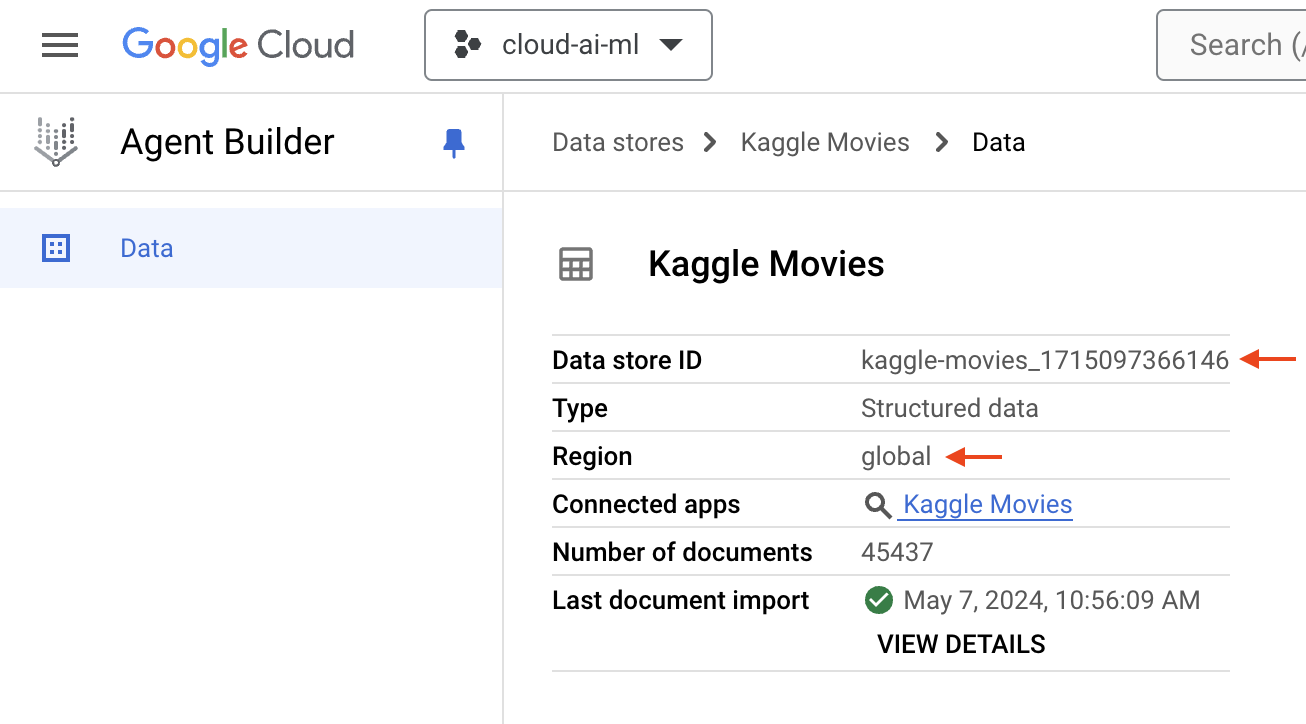

In [8]:
DATA_STORE_ID = "[your-data-store-id]"  # @param {type:"string"}
LOCATION_ID = "global"  # @param {type:"string"}

### Define Python functions as tools

The second component of your agent involves Python functions as tools, which will enable the Gemini model to interact with external systems, databases, document stores, and other APIs so that the model can get the most up-to-date information or take action with those systems.

In this example, you'll define a function that sends a query to Vertex AI Search and returns relevant records from the data store that you created in the previous section:

In [9]:
def search_kaggle_movies(query: str):
    """Search across records in the Kaggle Movies data set."""
    from langchain_google_community import VertexAISearchRetriever

    retriever = VertexAISearchRetriever(
        project_id=PROJECT_ID,
        data_store_id=DATA_STORE_ID,
        location_id=LOCATION_ID,
        engine_data_type=1,
        max_documents=10,
    )

    result = str(retriever.invoke(query))
    return result

Now you can test your search function with sample input to ensure that it's working as expected:

In [10]:
search_kaggle_movies("Harry Potter")

'[Document(page_content=\'{"runtime": "152", "tagline": "Let the Magic Begin.", "poster_path": "https://image.tmdb.org/t/p/original/wuMc08IPKEatf9rnMNXvIDxqP4W.jpg", "id": "671", "budget": "125000000", "original_language": "en", "status": "Released", "homepage": "http://harrypotter.warnerbros.com/harrypotterandthedeathlyhallows/mainsite/index.html", "popularity": 38.187238, "belongs_to_collection": "{\\\'id\\\': 1241, \\\'name\\\': \\\'Harry Potter Collection\\\', \\\'poster_path\\\': \\\'/8Xmkc1HvCOpMlbFvVabrtr6HAsp.jpg\\\', \\\'backdrop_path\\\': \\\'/wfnMt6LGqYHcNyOfsuusw5lX3bL.jpg\\\'}", "original_title": "Harry Potter and the Philosopher\\\'s Stone", "vote_count": "7188", "imdb_id": "tt0241527", "release_date": "2001-11-16", "spoken_languages": "[{\\\'iso_639_1\\\': \\\'en\\\', \\\'name\\\': \\\'English\\\'}]", "production_companies": "[{\\\'name\\\': \\\'1492 Pictures\\\', \\\'id\\\': 436}, {\\\'name\\\': \\\'Warner Bros.\\\', \\\'id\\\': 6194}, {\\\'name\\\': \\\'Heyday Films\\\

### Define agent

The third component of your agent involves adding a reasoning layer, which helps your agent use the tools that you provided to help the end user achieve a higher-level goal.

If you were to use Gemini and Function Calling on their own without a reasoning layer, you would need to handle the process of calling functions and APIs in your application code, and you would need to implement retries and additional logic to ensure that your function calling code is resilient to failures and malformed requests.

Define the prompt template and initialize the chat session history:

In [11]:
# Define prompt template
prompt = {
    "history": lambda x: x["history"],
    "input": lambda x: x["input"],
    "agent_scratchpad": (
        lambda x: format_to_openai_function_messages(x["intermediate_steps"])
    ),
} | prompts.ChatPromptTemplate.from_messages(
    [
        ("placeholder", "{history}"),
        ("user", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

# Initialize session history
store = {}


def get_session_history(session_id: str):
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]

Now you'll use the LangChain agent template provided in the Vertex AI SDK for Reasoning Engine, which brings together the model, tools, and reasoning that you've built up so far:

In [12]:
agent = reasoning_engines.LangchainAgent(
    prompt=prompt,
    model=model,
    chat_history=get_session_history,
    model_kwargs={"temperature": 0},
    tools=[search_kaggle_movies],
    agent_executor_kwargs={"return_intermediate_steps": True},
)

### Test your agent locally

Now you can test the model and agent behavior to ensure that it's working as expected before you deploy it:

In [13]:
response = agent.query(
    input="List some sci-fi movies from the 1990s",
    config={"configurable": {"session_id": "demo1234"}},
)

display(Markdown(response["output"]))

Here are some sci-fi movies from the 1990s:

* **The Matrix (1999):** A computer hacker learns from mysterious rebels about the true nature of his reality and his role in the war against its controllers.
* **Star Wars: Episode I - The Phantom Menace (1999):** Two Jedi Knights escape a hostile blockade to find a queen and her protector, and come across a young boy who may bring balance to the Force, but the long-dormant Sith resurface to claim their original power. 
* **Men in Black (1997):** A police officer joins a secret organization that polices and monitors extraterrestrial interactions on Earth. 
* **Starship Troopers (1997):** Humans in a fascist militaristic future wage war with giant alien bugs.
* **Gatace (1997):** A genetically inferior man assumes the identity of a superior one in order to pursue his lifelong dream of space travel. 
* **12 Monkeys (1995):** In the year 2035, a convict is sent back in time to gather information about the man-made virus that wiped out most of the human

### Deploy your agent on Vertex AI

Now that you've specified a model, tools, and reasoning for your agent and tested it out, you're ready to deploy your agent as a remote service in Vertex AI!

You can re-define the agent to avoid any stateful information in the agent due to our testing in the previous cell:

In [14]:
agent = reasoning_engines.LangchainAgent(
    prompt=prompt,
    model=model,
    chat_history=get_session_history,
    model_kwargs={"temperature": 0},
    tools=[search_kaggle_movies],
    agent_executor_kwargs={"return_intermediate_steps": True},
)

Now you're ready to deploy your agent to Reasoning Engine in Vertex AI by calling `reasoning_engines.ReasoningEngine.create()` along with the instance of your agent and the Python packages that your agent requires at runtime:

In [15]:
remote_agent = reasoning_engines.ReasoningEngine.create(
    agent,
    requirements=[
        "google-cloud-aiplatform==1.50.0",
        "langchain==0.1.17",
        "langchain-google-vertexai==1.0.3",
        "langchain_google_community",
        "google-cloud-discoveryengine",
    ],
)

Using bucket your-bucket-name
Writing to gs://your-bucket-name/reasoning_engine/reasoning_engine.pkl
Writing to gs://your-bucket-name/reasoning_engine/requirements.txt
Creating in-memory tarfile of extra_packages
Writing to gs://your-bucket-name/reasoning_engine/dependencies.tar.gz
Creating ReasoningEngine
Create ReasoningEngine backing LRO: projects/954731510984/locations/us-central1/reasoningEngines/5997035485053059072/operations/2550512418300100608
ReasoningEngine created. Resource name: projects/954731510984/locations/us-central1/reasoningEngines/5997035485053059072
To use this ReasoningEngine in another session:
reasoning_engine = vertexai.preview.reasoning_engines.ReasoningEngine('projects/954731510984/locations/us-central1/reasoningEngines/5997035485053059072')


### Grant Discovery Engine Editor access to Reasoning Engine service account

Before you send queries to your remote agent, you'll need to grant the **Discovery Engine Editor** role to the Reasoning Engine service account.

After you've completed this step, you remote agent will be able to retrieve documents from the data store that you created in Vertex AI Search:

In [16]:
# Retrieve the project number associated with your project ID
client = resourcemanager_v3.ProjectsClient()
project = client.get_project(name=f"projects/{PROJECT_ID}")
project_number = project.name.split("/")[-1]

In [17]:
# Add a new role binding to the IAM policy
!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member=serviceAccount:service-{project_number}@gcp-sa-aiplatform-re.iam.gserviceaccount.com \
    --role=roles/discoveryengine.editor

Updated IAM policy for project [your-project-id].
auditConfigs:
- auditLogConfigs:
  - logType: ADMIN_READ
  - logType: DATA_READ
  - logType: DATA_WRITE
  service: allServices
bindings:
- members:
  - serviceAccount:service-954731510984@gcp-sa-aiplatform-re.iam.gserviceaccount.com
  role: roles/discoveryengine.editor
etag: BwYX4TeUgNo=
version: 1


### Test your remotely deployed agent

With all of the core components of your community solar planning agent in place, you can send prompts to your remotely deployed agent to perform different tasks and test that it's working as expected:

In [18]:
response = remote_agent.query(
    input="List some sci-fi movies from the 1990s",
    config={"configurable": {"session_id": "demo"}},
)

display(Markdown(response["output"]))

Here are some sci-fi movies from the 1990s:

* **The Matrix (1999):** A computer hacker learns from mysterious rebels about the true nature of his reality and his role in the war against its controllers.
* **Star Wars: Episode I - The Phantom Menace (1999):** Two Jedi Knights escape a hostile blockade to find a queen and her protector, and come across a young boy who may bring balance to the Force, but the long-dormant Sith resurface to claim their original power. 
* **Men in Black (1997):** A police officer joins a secret organization that polices and monitors extraterrestrial interactions on Earth. 
* **Starship Troopers (1997):** Humans in a fascist militaristic future wage war with giant alien bugs.
* **Gatace (1997):** A genetically inferior man assumes the identity of a superior one in order to pursue his lifelong dream of space travel. 
* **12 Monkeys (1995):** In the year 2035, a convict is sent back in time to gather information about the man-made virus that wiped out most of the human

In [19]:
response = remote_agent.query(
    input="Who are the actors in The Matrix?",
    config={"configurable": {"session_id": "demo"}},
)

display(Markdown(response["output"]))

The main actors in The Matrix (1999) are:

* **Keanu Reeves** as Neo
* **Laurence Fishburne** as Morpheus 
* **Carrie-Anne Moss** as Trinity
* **Hugo Weaving** as Agent Smith 
* **Joe Pantoliano** as Cypher 


In [20]:
response = remote_agent.query(
    input="Are those actors in any other movies?",
    config={"configurable": {"session_id": "demo"}},
)

display(Markdown(response["output"]))

Yes, all of those actors have been in many other movies! Here are a few examples for each:

* **Keanu Reeves:** John Wick (2014), The Devil's Advocate (1997), Speed (1994), Bill & Ted's Excellent Adventure (1989)
* **Laurence Fishburne:**  Apocalypse Now (1979), Boyz n the Hood (1991), What's Love Got to Do with It (1993), Contagion (2011)
* **Carrie-Anne Moss:** Memento (2000), Chocolat (2000), Disturbia (2007), Jessica Jones (TV series, 2015-2019)
* **Hugo Weaving:** The Lord of the Rings trilogy (2001-2003), V for Vendetta (2005), Captain America: The First Avenger (2011), The Hobbit trilogy (2012-2014)
* **Joe Pantoliano:** The Goonies (1985), Risky Business (1983), The Fugitive (1993), Memento (2000) 


### Reusing your deployed agent from other applications or SDKs

You can now import and use the remotely deployed Reasoning Engine in this notebook session or in a different notebook or Python script by uncommenting and adapting the following code:

In [21]:
# from vertexai.preview import reasoning_engines

# PROJECT_ID = "YOUR_PROJECT_ID"
# LOCATION = "YOUR_LOCATION"
# REASONING_ENGINE_ID = "YOUR_REASONING_ENGINE_ID"

# remote_agent = reasoning_engines.ReasoningEngine(f"projects/{PROJECT_ID}/locations/{LOCATION}/reasoningEngines/{REASONING_ENGINE_ID}")
# response = remote_agent.query(input=query)

Or, you can query your agent from other programming languages using any of the [available client libraries in Vertex AI](https://cloud.google.com/vertex-ai/docs/start/client-libraries), including C#, Java, Node.js, Python, Go, or REST API.